In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as p
import os
from scipy import integrate
import copy
from joblib import Parallel, delayed
from time import time
from math import pi
import shutil
from datetime import datetime
import pickle
import matplotlib.patches as patches


In [20]:
###########
###plots###
###########
def plot_vol_pop_single(pop_dires,single_dires,labels, save_name,save_dir, t_start, t_stop):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 14})
    
    pop_dir_nr = len(pop_dires)
    single_dir_nr = len(single_dires)
    f,(a0,a1) = plt.subplots(1,2,gridspec_kw={'width_ratios':[3,1]},figsize=(16,8))
    for l,pop_dir in enumerate(pop_dires):   #l is used for alpha_shade
        pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    
        zahl = max([len(Cell.species_growth_m['r']) for Cell in pop]) # "zahl" is the simulation time of the oldest cell
        if t_stop > zahl:
            t_stop = zahl
        nr_cells=len(pop)
        tmp2=np.zeros((nr_cells,t_stop),dtype=float)   #2D array with one array of length(t_stop) for every cell
        tmp_mn=[]
        tmp_sd=[]
        i=1
        for k1, Cell in enumerate(pop):
            if np.any(Cell.species_growth_m['r']) and zahl-len(Cell.species_growth_m['r']) < t_stop:
                #assemble results of species X for cell number k1
                for k2, m, d in zip(range(zahl-len(Cell.species_growth_m['r']),t_stop),Cell.species_growth_m['r'],cell.species_growth_d['r']):
                    tmp2[k1,k2] = 4/3*pi*(m**3 + d**3)
        for m in range(t_stop):
            #for every timestep calculate mean and standard 
            #deviation of all cells living at that time
            tmp_list=[np.log10(n) for n in tmp2[:,m] if n!=0] #log-scale
            tmp_mn.append(np.mean(tmp_list))
            tmp_sd.append(np.std(tmp_list))
        tmp_mn=np.array(tmp_mn)
        tmp_sd=np.array(tmp_sd)

        x_values = [i*1 for i in range(t_stop)]   #zahl-len(tmp_mn)
        print(len(tmp_mn),len(tmp_sd),len(x_values))

        p1,=a0.plot(x_values,tmp_mn,color=(1,1-0.7*(l+1)/pop_dir_nr,0), linewidth=2)
        a0.fill_between(x_values, tmp_mn-tmp_sd, tmp_mn+tmp_sd, color=(1,1-0.7*(l+1)/pop_dir_nr,0), alpha=0.2,label=labels[l])
        a0.plot(x_values, tmp_mn-tmp_sd, color=(1,1-0.7*(l+1)/pop_dir_nr,0),lw=0.3) # plot black line along standart deviation lower end
        a0.plot(x_values, tmp_mn+tmp_sd, color=(1,1-0.7*(l+1)/pop_dir_nr,0),lw=0.3) # plot black line along standart deviation upper end
        # Create a Rectangle patch
        rect = patches.Rectangle((0, .8), .001, .001,facecolor=(1,1-0.7*(l+1)/pop_dir_nr,0), alpha=1,edgecolor='black',lw=0.3)
        # Add the patch to the Axes
        a0.add_patch(rect)
        legend1 = a0.legend([p1,rect],('Mean','Standard deviation'),loc='lower right',shadow=True)
        #a0.legend()
        #a0.add_artist(legend1)
        f.tight_layout()
    a0.set_yticks([np.log10(q) for q in np.linspace(10,250,7)])
    a0.set_yticklabels(np.linspace(10,250,7))
    a0.set_xlabel('Time (min)')
    a0.set_ylabel('Cell Volume (fL)')
    a0.set_title('A',loc='left')
    
    plots=[]
    for l,single_dir in enumerate(single_dires):
        single = pickle.load(open(single_dir + 'pop.p','rb'))
        Cell = single[0]
        x_values = range(len(Cell.species_growth_m['r']))
        y_values = [4*pi/3*Cell.species_growth_m['r'][i]**3 for i in range(len(Cell.species_growth_m['r']))]
        p,=a1.plot(x_values,y_values,color=(1,1-0.7*(l+1)/single_dir_nr,0),linewidth=2)
        plots.append(p)
        a1.set_xlabel('Time (min)')
        a1.set_title('B',loc='left')
        if l == 0:   #mirror y axis only once
            a1_ = a1.twinx()
            #ylabel = a1.get_yticklabels()
            #a1_.set_yticklabels(ylabel)
            a1_.set_ylabel('Cell Volume (fL)')
            a1_.set_yticklabels([])
            a1_.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,         # ticks along the left edge are off
                right=False,         # ticks along the right edge are off
                labelbottom=False)
    a1.legend(plots,labels,loc='lower right',shadow=True)

    
    f.savefig(save_dir + save_name,bbox_inches='tight')


def plot_pop_volume_life(pop_, xlab, ylab, save_name, int_1, int_2, save_dir):
    import matplotlib.pyplot as plt
    if isinstance(pop_[0],cell ):
        pop = pop_
    else:
        pop = pickle.load(open(pop_+'pop.p','rb'))
    font = {'size'   : 14}
    matplotlib.rc('font', **font)

    logit = True
    f1 = p.figure()
    tmp=[]
    
    X = 'r'
    #zahl=2000
    #tmp2=zeros((zahl,zahl),dtype=float)

    zahl = max([len(Cell.species_growth_m[X]) for Cell in pop]) # "zahl" is the simulation time of the oldest cell
    nr_cells=len(pop)
    tmp2=np.zeros((nr_cells,zahl),dtype=float)   #2D array with one array of length(zahl) for every cell

    tmp_mn=[]
    tmp_sd=[]
    i=1
    for k1, Cell in enumerate(pop):
        if np.any(Cell.species_growth_m[X]):
            #assemble results of species X for cell number k1
            for k2, m, d in zip(range(zahl-len(Cell.species_growth_m[X]),zahl),Cell.species_growth_m[X],Cell.species_growth_d[X]):
                tmp2[k1,k2] = 4/3*pi*(m**3 + d**3)
            #plot in range between int_1 and int_2, check if log scale should be used
            if not logit and len(Cell.species_growth_m[X])>=int_1 and i <= int_2:
                p.plot(range(zahl-len(Cell.species_growth_m[X]),zahl),Cell.species_growth_m[X], alpha=0.1)
                i += 1
            elif len(Cell.species_growth_m[X])>=int_1 and i <= int_2:
                p.plot(range(zahl-len(Cell.species_growth_m[X]),zahl),np.log10(Cell.species_growth_m[X]), alpha=0.1) #log-scale
                #p.xlim(400,600)
                i += 1
    #for every timestep calculate mean and standard deviation of all cells living at that time
    for m in range(zahl):
        if not logit: tmp_list=[n for n in tmp2[:,m] if n!=0]
        else: tmp_list=[np.log10(n) for n in tmp2[:,m] if n!=0] #log-scale
        tmp_mn.append(np.mean(tmp_list))
        tmp_sd.append(np.std(tmp_list))
    tmp_mn=np.array(tmp_mn)
    tmp_sd=np.array(tmp_sd)
    print (tmp_mn[-1], tmp_sd[-1])

    p.text(50,1,'%s size %s var'%(round(tmp_mn[-1],2),round(tmp_sd[-1],2)) )

    x_values = [i*1 for i in range(zahl-len(tmp_mn),zahl)]

    p1,=p.plot(x_values, tmp_mn, color='#25597c',lw=3)
    p.fill_between(x_values, tmp_mn-tmp_sd, tmp_mn+tmp_sd, color='#82bcd3', alpha=1 )

    p.plot(x_values, tmp_mn-tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation lower end
    p.plot(x_values, tmp_mn+tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation upper end

    r = p.Rectangle((0, 0), .2, .2,facecolor='#82bcd3', alpha=1,edgecolor='black',lw=0.3) # creates rectangle patch for legend use.

    p.legend([p1,r],('Mean','Standard deviation'),loc='lower right',shadow=True)

    p.yticks([np.log10(q) for q in np.linspace(10,250,7)],np.linspace(10,250,7))

    p.xlabel(xlab)
    p.ylabel(ylab)
    #p.title('linear')
    f1.tight_layout()
    f1.savefig(save_dir + save_name)
    
def plot_X_cyclins_life(pop, X, xlab, ylab, save_name, int_1, int_2, meansd):
    import matplotlib.pyplot as plt
    font = {'size'   : 14}
    matplotlib.rc('font', **font)

    logit = True
    f1 = p.figure()
    tmp=[]

    #zahl=2000
    #tmp2=zeros((zahl,zahl),dtype=float)

    zahl = max([len(cell.species_growth_m[X]) for cell in pop]) # "zahl" is the simulation time of the oldest cell
    nr_cells=len(pop)
    tmp2=np.zeros((nr_cells,zahl),dtype=float)

    tmp_mn=[]
    tmp_sd=[]
    i=1
    for k1, cell in enumerate(pop):
        if np.any(cell.species_cyclins[X]):
          if meansd:
            tmp.append(cell.species_cyclins[X])
          else:
            #p.plot(range(len(vector[X])),vector[X])
            for k2, v in zip(range(zahl-len(cell.species_cyclins[X]),zahl),cell.species_cyclins[X]):
              tmp2[k1,k2] = v
            if not logit and len(cell.species_cyclins[X])>=int_1 and i <= int_2:
              p.plot(range(zahl-len(cell.species_cyclins[X]),zahl),cell.species_cyclins[X], alpha=0.1)
              i += 1
            elif len(cell.species_cyclins[X])>=int_1 and i <= int_2:
              p.plot(range(zahl-len(cell.species_cyclins[X]),zahl),np.log10(cell.species_cyclins[X]), alpha=0.1) #log-scale
              #p.xlim(400,600)
              i += 1
    for m in range(zahl):
        if not logit: tmp_list=[n for n in tmp2[:,m] if n!=0]
    else: tmp_list=[np.log10(n) for n in tmp2[:,m] if n!=0] #log-scale
    tmp_mn.append(np.mean(tmp_list))
    tmp_sd.append(np.std(tmp_list))
    tmp_mn=np.array(tmp_mn)
    tmp_sd=np.array(tmp_sd)
    print (tmp_mn[-1], tmp_sd[-1])

    p.text(50,1,'%s size %s var'%(round(tmp_mn[-1],2),round(tmp_sd[-1],2)) )

    x_values = [i*1 for i in range(zahl-len(tmp_mn),zahl)]

    p1,=p.plot(x_values, tmp_mn, color='#25597c',lw=3)
    p.fill_between(x_values, tmp_mn-tmp_sd, tmp_mn+tmp_sd, color='#82bcd3', alpha=1 )

    p.plot(x_values, tmp_mn-tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation lower end
    p.plot(x_values, tmp_mn+tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation upper end

    r = p.Rectangle((0, 0), 1, 1,facecolor='#82bcd3', alpha=1,edgecolor='black',lw=0.3) # creates rectangle patch for legend use.

    p.legend([p1,r],('Mean','Standard deviation'),loc='upper left',shadow=True)

    p.yticks([np.log10(q) for q in np.linspace(10,250,7)],np.linspace(10,250,7))

    if meansd:
        tmp=[i[:int_1] for i in tmp] # alle gleich gross
    mn=np.mean(tmp,0)
    sd=np.std(tmp,0)
    p.fill_between(range(len(mn)), mn-sd, mn+sd, color='lightblue', alpha=0.5 )
    p.plot(range(len(mn)), mn, color='blue')
    p.xlabel(xlab)
    p.ylabel(ylab)
    #p.title('linear')
    f1.savefig(save_name)


def calc_dr(i,r,c_i,pi_t,V_os):
    A = 4*pi*r**2
    pi_i = c_i * R * T
    pi_e = ce * R * T
    dV_os = - Lp * A *(pi_t + (pi_e - pi_i))
    dr = 1/3*(3/4/pi*k_b/(k_b-k_D))**(1/3)*dV_os/V_os**(2/3)
    return dr

def get_dr(cell,life_length,MoDo='m'):
    dr_array = np.zeros(life_length)
    for i in range(life_length):
        if MoDo == 'm':
            r = cell.species_growth_m['r'][i]
            c_i = cell.species_growth_m['c_i'][i]
            pi_t = cell.species_growth_m['pi_t'][i]
            V_os = cell.species_growth_m['V_os'][i]
        if MoDo == 'd':
            r = cell.species_growth_d['r'][i]
            c_i = cell.species_growth_d['c_i'][i]
            pi_t = cell.species_growth_d['pi_t'][i]
            V_os = cell.species_growth_d['V_os'][i]
        dr_array[i] = calc_dr(i,r,c_i,pi_t,V_os)
    return dr_array
    
def get_r_ccrit(cell,life_length,MoDo = 'm'):
    r_ccrit = np.zeros(life_length)
    for i in range(life_length):
        if MoDo == 'm':
            r = cell.species_growth_m['r'][i]
            c_i = cell.species_growth_m['c_i'][i]
            pi_t = cell.species_growth_m['pi_t'][i]
            V_os = cell.species_growth_m['V_os'][i]
        if MoDo == 'd':
            r = cell.species_growth_d['r'][i]
            c_i = cell.species_growth_d['c_i'][i]
            pi_t = cell.species_growth_d['pi_t'][i]
            V_os = cell.species_growth_d['V_os'][i]
        r_ccrit[i] = 3*(k_uptake-c_i*calc_dr(i,r,c_i,pi_t,V_os))/k_maintenance
    return r_ccrit

def get_r_picrit(cell,life_length,MoDo = 'm'):
    r_picrit = np.zeros(life_length)
    for i in range(life_length):
        if MoDo == 'm':
            pi_t = cell.species_growth_m['pi_t'][i]
            r_picrit[i] = 2*E*d/(1-nu)/pi_t
        if MoDo == 'd':
            pi_t = cell.species_growth_d['pi_t'][i]
            r_picrit[i] = 2*E_d*d/(1-nu)/pi_t
        
    return r_picrit
    
def plot_species(cell,save_dir,cell_nr,plot_conc = False):
    import matplotlib.pyplot as plt
    spec_nr = int(len(cell.species_cyclins)/2) +len(cell.species_growth_m) +2
    fig,ax = plt.subplots(spec_nr,2,figsize=(32,64))
    i = 0
    h = 0
    for spec in cell.species_cyclins:
        life_length = len(cell.species_cyclins[spec])
        t = np.linspace(0,life_length-1,life_length)
        if plot_conc:
            ax[i][h].plot(t,cell.species_cyclins[spec]/(cell.species_growth_m['V_os']+cell.species_growth_m['V_b']+
                                                    cell.species_growth_d['V_os']+cell.species_growth_d['V_b']))
        else:    
            ax[i][h].plot(t,cell.species_cyclins[spec])        
        ax[i][h].set_xlabel('t')
        ax[i][h].legend([spec], shadow=True)
        if h == 0:
            h = 1
        elif h == 1:
            h = 0
            i += 1
    j = 0
    for spec in cell.species_growth_m:
        life_length = len(cell.species_growth_m[spec])
        t = np.linspace(0,life_length-1,life_length)
        '''if spec == 'r':
            r_ccrit = get_r_ccrit(cell,life_length,MoDo='m')
            r_picrit = get_r_picrit(cell,life_length,MoDo='m')
            ax[i+j][0].plot(t,r_ccrit,label='r_ccrit')
            ax[i+j][0].plot(t,r_picrit,label='r_picrit')'''
        ax[i+j][0].plot(t,cell.species_growth_m[spec])
        ax[i+j][0].set_xlabel('t')
        ax[i+j][0].legend([spec], shadow=True)
        j += 1
    k = 0
    for spec in cell.species_growth_d:
        life_length = len(cell.species_growth_d[spec])
        t = np.linspace(0,life_length-1,life_length)
        '''if spec == 'r':
            r_ccrit = get_r_ccrit(cell,life_length,MoDo='d')
            r_picrit = get_r_picrit(cell,life_length,MoDo='d')
            ax[i+k][1].plot(t,r_ccrit,label='r_ccrit')
            ax[i+k][1].plot(t,r_picrit,label='r_picrit')'''
        ax[i+k][1].plot(t,cell.species_growth_d[spec])
        ax[i+k][1].set_xlabel('t')
        ax[i+k][1].legend([spec], shadow=True)
        k += 1
    ax[i+k][0].plot(t,cell.species_growth_m['B_R']/(4/3*pi*cell.species_growth_m['r']**3))
    ax[i+k][0].set_xlabel('t')
    ax[i+k][0].legend(['B_R/V'], shadow = True)
    ax[i+k][1].plot(t,cell.species_growth_d['B_R']/(4/3*pi*cell.species_growth_d['r']**3))
    ax[i+k][1].set_xlabel('t')
    ax[i+k][1].legend(['B_R/V'], shadow = True)
    
    dr_array = get_dr(cell,life_length,MoDo='m')
    ax[i+k+1][0].plot(t,dr_array)
    ax[i+k+1][0].set_xlabel('t')
    ax[i+k+1][0].legend(['dr'], shadow = True)
    dr_array = get_dr(cell,life_length,MoDo='d')
    ax[i+k+1][1].plot(t,dr_array)
    ax[i+k+1][1].set_xlabel('t')
    ax[i+k+1][1].legend(['dr'], shadow = True)
    fig.savefig(save_dir+'cell_%d'%cell_nr)
    plt.close(fig)
    print('figure save')

def plot_G1(pop_dir,save_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load(open(pop_dir+'pop.p','rb'))
    max_gen_nr = max([len(cell.times_in_g1) for cell in pop])
    #cut off last generations with few cell, to prevent strong variance in later generations
    sort_gen = np.zeros(max_gen_nr)
    for cell in pop:
        if len(cell.times_in_g1):
            sort_gen[len(cell.times_in_g1)-1] += 1
    max_cell_count = max(sort_gen)
    cut_off = min(max_cell_count/10,25)
    cut = False
    i = 0
    while cut==False:
        if sort_gen[i] < cut_off:
            cut = True
        i+=1
    max_gen_nr = i
    
    mean_all_gen = []
    std_all_gen = []
    for gen in range(max_gen_nr):
        gen_array = [cell.times_in_g1[gen] for cell in pop if len(cell.times_in_g1) > gen]
        mean_all_gen.append(np.mean(gen_array))
        std_all_gen.append(np.std(gen_array))
    X = np.arange(max_gen_nr)
    fig = plt.figure()
    plt.errorbar(X,mean_all_gen,std_all_gen,linestyle='None', marker='s',linewidth=4,label='Mean duration and standard deviation')
    plt.xlabel('generation')
    plt.xticks(X)
    plt.ylabel('time (min)')
    plt.legend(loc = 'upper right')
    fig.tight_layout()
    fig.savefig(save_dir+'TG1')
    plt.show()
    
def plot_G2(pop_dir,save_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load(open(pop_dir+'pop.p','rb'))
    max_gen_nr = max([len(cell.times_in_G2) for cell in pop])
    #cut off last generations with few cell, to prevent strong variance in later generations
    sort_gen = np.zeros(max_gen_nr)
    for cell in pop:
        if len(cell.times_in_G2):
            sort_gen[len(cell.times_in_G2)-1] += 1
    max_cell_count = max(sort_gen)
    cut_off = min(max_cell_count/10,25)
    cut = False
    i = 0
    while cut==False:
        if sort_gen[i] < cut_off:
            cut = True
        i+=1
    max_gen_nr = i
    mean_all_gen = []
    std_all_gen = []
    for gen in range(max_gen_nr):
        gen_array = [cell.times_in_G2[gen] for cell in pop if len(cell.times_in_G2) > gen]
        mean_all_gen.append(np.mean(gen_array))
        std_all_gen.append(np.std(gen_array))
    X = np.arange(max_gen_nr)
    fig = plt.figure()
    plt.errorbar(X,mean_all_gen,std_all_gen,linestyle='None', marker='s',linewidth=4,label='Mean duration and standard deviation')
    plt.xlabel('generation')
    plt.xticks(X)
    plt.ylabel('time (min)')
    plt.legend(loc = 'upper right')
    fig.tight_layout()
    fig.savefig(save_dir+'TG2')
    plt.show()
    
def plot_G1_growth(dires,labels,save_dir):
    import matplotlib.pyplot as plt
    pop_dir_nr = len(dires)
    max_gen_nr = 0
    markers = ['o','v','s','8','P','+']
    plots = []
    fig = plt.figure(figsize=(12,8))
    for l, pop_dir in enumerate(dires):
        pop = pickle.load(open(pop_dir+'pop.p','rb'))
        gen_nr = max([len(cell.times_in_g1) for cell in pop])
        #cut off last generations with few cell, to prevent strong variance in later generations
        sort_gen = np.zeros(gen_nr)
        for cell in pop:
            if len(cell.times_in_g1):
                sort_gen[len(cell.times_in_g1)-1] += 1
        max_cell_count = max(sort_gen)
        cut_off = min(max_cell_count/10,25)
        cut = False
        i = 0
        while cut==False:
            if sort_gen[i] < cut_off:
                cut = True
            i+=1
        gen_nr = i
        if gen_nr > max_gen_nr:
            max_gen_nr = gen_nr

        mean_all_gen = []
        std_all_gen = []
        for gen in range(gen_nr):
            gen_array = [cell.times_in_g1[gen] for cell in pop if len(cell.times_in_g1) > gen]
            mean_all_gen.append(np.mean(gen_array))
            std_all_gen.append(np.std(gen_array))
        X = np.arange(gen_nr) + l*0.11 
        p=plt.errorbar(X,mean_all_gen,std_all_gen,color=(1,1-0.7*(l+1)/pop_dir_nr,0),linestyle='None',elinewidth=0.8, marker=markers[l],linewidth=2)
        plots.append(p)
    X = np.arange(max_gen_nr)
    plt.xlabel('generation')
    plt.xticks(X)
    plt.ylabel('time (min)')
    plt.legend(plots,labels,loc = 'upper right')
    fig.tight_layout()
    fig.savefig(save_dir+'TG1_growth')
    plt.show()
    
def plot_G1G2_md(pops,model_dir):
    import matplotlib.pyplot as plt
    colors=['b','g','r','c','m','y']
    fig = plt.figure()
    i = 0
    for pop in pops:
        TG1d = np.mean([cell.times_in_g1[0] for cell in pop if cell.times_in_g1])
        TG2d = np.mean([cell.times_in_G2[0] for cell in pop if cell.times_in_G2])
        t1 = []
        t2 = []
        for cell in pop:
            if len(cell.times_in_g1) > 1:
                t1.append(np.mean(cell.times_in_g1[1:]))
            if len(cell.times_in_G2) > 1:    
                t2.append(np.mean(cell.times_in_G2[1:]))
        TG1 = np.mean(t1)
        TG2 = np.mean(t2)
        plt.plot(TG2,TG1,'%s'%colors[i]+'s',label='mother')
        plt.plot(TG2d,TG1d,'%s'%colors[i]+'^',label='daughter')
        i += 1
    plt.xlabel('G2')
    plt.ylabel('G1')
    plt.legend()
    fig.savefig(model_dir + 'G1G2_md')
    plt.show()
    
def plot_birthsize_G1(pop_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    TG1 = []
    Vbirth = []
    for cell in pop:
        if cell.times_in_g1:
            TG1.append(cell.times_in_g1[0])
            Vbirth.append(cell.species_growth_m['r'][0]**3*4*pi/3)
    fig = plt.figure()
    plt.plot(Vbirth,TG1,'bo')
    plt.xlabel('V at birth(fL)')
    plt.ylabel('Duration of first G1 phase(min)')
    fig.savefig(pop_dir + 'birthsize_G1')
    plt.show()
    
def plot_deltaVG1_birthsize(pop_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    VG1 = []
    Vbirth = []
    for cell in pop:
        if cell.times_in_g1:
            Vbirth.append(cell.species_growth_m['r'][0]**3*4*pi/3)
            TG1 = cell.times_in_g1[0]
            VG1.append(cell.species_growth_m['r'][TG1]**3*4*pi/3 - cell.species_growth_m['r'][0]**3*4*pi/3)
    fig = plt.figure()
    plt.plot(Vbirth,VG1,'bo')
    plt.xlabel('V at birth(fL)')
    plt.ylabel('Delta V in first G1')
    fig.savefig(pop_dir + 'birthsize_VG1')
    plt.show()
    
def plot_Vdiv_VG1(pop_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    VG1 = []
    Vdiv = []
    
    TS = 25
    TM = 5
    for cell in pop:
        if cell.times_in_G2:
            pre_div_nr = len(cell.times_in_G2)
            t = sum(cell.times_in_g1[:pre_div_nr]) + sum(cell.times_in_G2[:pre_div_nr]) + (TS + TM)*pre_div_nr
            if t <= cell.lifetime:
                div_nr = pre_div_nr
            else: 
                div_nr = pre_div_nr -1
            if len(cell.times_in_g1) > div_nr:
                gen_nr = div_nr
            else:
                gen_nr = div_nr -1
            for i in range(gen_nr):    
                Tdiv = cell.times_in_g1[i] + TS + cell.times_in_G2[i] + TM
                Vdiv.append(cell.species_growth_m['r'][Tdiv]**3*4*pi/3)
                TG1 = cell.times_in_g1[i+1]
                VG1.append(cell.species_growth_m['r'][Tdiv + TG1]**3*4*pi/3 - cell.species_growth_m['r'][Tdiv]**3*4*pi/3)
    fig = plt.figure()
    plt.plot(Vdiv,VG1,'bo')
    plt.xlabel('V at division(fL)')
    plt.ylabel('Delta V in next G1')
    fig.savefig(pop_dir + 'Vdivision_VG1')
    plt.show()
    
def plot_Vdiv_gen(pop_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    Gen = []
    Vdiv = []
    TS = 25
    TM = 5
    for cell in pop:
        if cell.times_in_G2:
            pre_div_nr = len(cell.times_in_G2)
            t = sum(cell.times_in_g1[:pre_div_nr]) + sum(cell.times_in_G2[:pre_div_nr]) + (TS + TM)*pre_div_nr
            if t <= cell.lifetime:
                gen_nr = pre_div_nr
            else: 
                gen_nr = pre_div_nr -1
            for i in range(gen_nr):    
                Tdiv = cell.times_in_g1[i] + TS + cell.times_in_G2[i] + TM
                Vdiv.append(cell.species_growth_m['r'][Tdiv]**3*4*pi/3)
                Gen.append(i)
    fig = plt.figure()
    plt.plot(Gen,Vdiv,'bo')
    plt.xlabel('genealogical age')
    plt.ylabel('V at division(fL)')
    fig.savefig(pop_dir + 'Vdivision_gen')
    plt.show()
    
def plot_Vdiv_Vbirth(pop_dir):
    import matplotlib.pyplot as plt
    pop = pickle.load( open(pop_dir +'pop'+'.p','rb') )
    Vbirth = []
    Vdiv = []
    TS = 25
    TM = 5
    for cell in pop:
        if cell.times_in_G2:
            pre_div_nr = len(cell.times_in_G2)
            t = sum(cell.times_in_g1[:pre_div_nr]) + sum(cell.times_in_G2[:pre_div_nr]) + (TS + TM)*pre_div_nr
            if t <= cell.lifetime:
                gen_nr = pre_div_nr
            else: 
                gen_nr = pre_div_nr -1
            for i in range(gen_nr):    
                Tdiv = cell.times_in_g1[i] + TS + cell.times_in_G2[i] + TM
                Vdiv.append(cell.species_growth_m['r'][Tdiv]**3*4*pi/3)
                Vbirth.append(cell.species_growth_d['r'][Tdiv]**3*4*pi/3)
    fig = plt.figure()
    plt.plot(Vdiv,Vbirth,'bo')
    plt.xlabel('V at division(fL)')
    plt.ylabel('V of new daughter(fL)')
    fig.savefig(pop_dir + 'Vdivision_gen')
    plt.show()
    
def plot_size_distr(dire,growth_rates,labels):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 14})
    color = ['bo','gv','rs','c8','mP','y+']
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.tight_layout(pad=3.0)
    for i in range(len(dire)):
        dire[i] = [dire[i] + '%s' %str(rate) + '/' for rate in growth_rates ]
        mn = []
        std = []
        mn_log = []
        std_log = []
        for p_dir in dire[i]:
            pop = pickle.load( open(p_dir +'pop'+'.p','rb') ) 
            cell_nr = len(pop)
            cell_array = np.zeros(cell_nr)
            for k,cell in enumerate(pop):
                cell_array[k] = 4*pi/3*(cell.species_growth_m['r'][-1]**3 + cell.species_growth_d['r'][-1]**3)
            mean_vol = np.mean(cell_array)
            std_vol = np.std(cell_array)

            cell_array_log = np.log10(cell_array)
            mean_vol_log = np.mean(cell_array_log)
            std_vol_log = np.std(cell_array_log)

            mn.append(mean_vol)
            std.append(std_vol)
            mn_log.append(mean_vol_log)
            std_log.append(std_vol_log)
            
        ax[0].plot(growth_rates,mn,color[i],label=labels[i])
        ax[1].plot(growth_rates,std_log, color[i],label=labels[i])
        #ax[2].plot(mn,std_log,color[i],label=labels[i])
    ax[0].set_xlabel('growth factor')
    ax[1].set_xlabel('growth factor')
    #ax[2].set_xlabel('mean cell volume (fL)')
    ax[0].set_ylabel('mean cell volume (fL)')
    ax[1].set_ylabel('standard variation of log(volume)')
    #ax[2].set_ylabel('standard variation of log(volume)')
    #ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper right')
    fig.savefig('./size_distr')
    plt.show()
    
def plot_coupled_sim(dires,titles,save_dir):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3,3,sharex='col',sharey='row',figsize=(12,12))
    fig.subplots_adjust(hspace=0,wspace=0)
    for k,pop_dir in enumerate(dires):
        pop = pickle.load(open(pop_dir +'pop'+'.p','rb'))
        cell = pop[0]
        sim_len = len(cell.species_growth_m['r'])
        t = np.linspace(0,sim_len-1,sim_len)
        Vm_array = np.zeros(sim_len)
        Vd_array = np.zeros(sim_len)
        cim_array = np.zeros(sim_len)
        cid_array = np.zeros(sim_len)
        pim_array = np.zeros(sim_len)
        pid_array = np.zeros(sim_len)
        for i in range(sim_len):
            Vm_array[i] = cell.species_growth_m['r'][i]#4*pi/3*cell.species_growth_m['r'][i]**3
            Vd_array[i] = cell.species_growth_d['r'][i]#4*pi/3*cell.species_growth_d['r'][i]**3
            cim_array[i] = cell.species_growth_m['c_i'][i]
            cid_array[i] = cell.species_growth_d['c_i'][i]
            pim_array[i] = cell.species_growth_m['pi_t'][i]
            pid_array[i] = cell.species_growth_d['pi_t'][i]
        p1,=ax[0,k].plot(t,Vm_array,color='b')
        p2,=ax[0,k].plot(t,Vd_array,color='orange')
        ax[1,k].plot(t,cim_array,color='b')
        ax[1,k].plot(t,cid_array,color='orange')
        ax[2,k].plot(pim_array,color='b')
        ax[2,k].plot(pid_array,color='orange')
        ax[2,k].set_xlabel('Time (min)')
        ax[0,k].set_title(titles[k])
        if k != 0:    
            ax[0,k].tick_params(axis='y',which='both',left=False)
            ax[1,k].tick_params(axis='y',which='both',left=False)
            ax[2,k].tick_params(axis='y',which='both',left=False)
    ax[0,0].set_ylabel('Radius (micro m)')
    ax[1,0].set_ylabel('Concentration (mM)')
    ax[2,0].set_ylabel('Pressure (Pa)')
    ax[0,0].legend([p1,p2],['Mother','Bud'],loc='upper left',fontsize='medium')
    
    
    #fig.tight_layout(pad=3.0)
    fig.savefig('./coupled_sim')
    plt.show()
    
def plot_single_r_ci_pi(dires,titles,save_dir):
    dir_nr = len(dires)
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 14.5})
    fig, ax = plt.subplots(3,dir_nr,sharex='col',figsize=(6*dir_nr,8))
    fig.subplots_adjust(hspace=0.15,wspace=0.35)
    for k,pop_dir in enumerate(dires):
        pop = pickle.load(open(pop_dir +'pop'+'.p','rb'))
        cell = pop[0]
        sim_len = len(cell.species_growth_m['r'])
        t = np.linspace(0,sim_len-1,sim_len)
        Vm_array = np.zeros(sim_len)
        cim_array = np.zeros(sim_len)
        pim_array = np.zeros(sim_len)
        for i in range(sim_len):
            Vm_array[i] = cell.species_growth_m['r'][i]#4*pi/3*cell.species_growth_m['r'][i]**3
            cim_array[i] = cell.species_growth_m['c_i'][i]
            pim_array[i] = cell.species_growth_m['pi_t'][i]
        if dir_nr > 1:
            ax[0,k].plot(t,Vm_array)
            ax[1,k].plot(t,cim_array)
            ax[2,k].plot(t,pim_array)
            ax[2,k].set_xlabel('Time (min)')
            ax[0,k].set_title(titles[k])
        elif dir_nr == 1:
            ax[0].plot(t,Vm_array)
            ax[1].plot(t,cim_array)
            ax[2].plot(t,pim_array)
            ax[2].set_xlabel('Time (min)')
            ax[0].set_title(titles[k])
    if dir_nr > 1:
        ax[0,0].set_ylabel('Radius (micro m)')
        ax[1,0].set_ylabel('Concentration (mM)')
        ax[2,0].set_ylabel('Pressure (Pa)')
    elif dir_nr == 1:       
        ax[0].set_ylabel('Radius (micro m)')
        ax[1].set_ylabel('Concentration (mM)')
        ax[2].set_ylabel('Pressure (Pa)')
    fig.savefig('./single_analysis')
    plt.show()
    
def plot_single_cyclin_BGM(dires,titles,save_dir):
    dir_nr = len(dires)
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(2,dir_nr,sharex='col',sharey='row',figsize=(12,8))
    for k,pop_dir in enumerate(dires):
        pop = pickle.load(open(pop_dir + 'pop.p','rb'))
        cell = pop[0]
        sim_len = len(cell.species['mCLN'])
        t = np.linspace(0,sim_len-1,sim_len)
        mCLN_array = np.zeros(sim_len)
        Cln_array = np.zeros(sim_len)
        for i in range(sim_len):
            V = (cell.species['B_Am'][i]**1.5+cell.species['B_Ad'][i]**1.5)
            mCLN_array[i] = cell.species['mCLN'][i]/V
            Cln_array[i] = cell.species['Cln'][i]/V
        alph = 1/(1+k)
        ax[0,k].plot(t,mCLN_array,label = 'mCLN',alpha=alph)
        ax[1,k].plot(t,Cln_array,label = 'Cln',alpha=alph)
        ax[0,k].set_title(titles[k])
        ax[1,k].set_xlabel('Time (min)')
        if k != 0:    
            ax[0,k].tick_params(axis='y',which='both',left=False)
            ax[1,k].tick_params(axis='y',which='both',left=False)
        ax[0,k].tick_params(axis='x',which='both',bottom=False)
        ax[0,k].legend()
        ax[1,k].legend()
    ax[0,0].set_ylabel('Concentration (#/fL)')
    ax[1,0].set_ylabel('Concentration (#/fL)')
    fig.savefig('./single_cyclins')
    plt.show()
    
def plot_single_cyclin(dires,titles,save_dir):
    dir_nr = len(dires)
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(2,dir_nr,sharex='col',sharey='row',figsize=(12,8))
    for k,pop_dir in enumerate(dires):
        pop = pickle.load(open(pop_dir + 'pop.p','rb'))
        cell = pop[0]
        sim_len = len(cell.species_cyclins['mCLN'])
        t = np.linspace(0,sim_len-1,sim_len)
        mCLN_array = np.zeros(sim_len)
        Cln_array = np.zeros(sim_len)
        for i in range(sim_len):
            V = 4*pi/3*(cell.species_growth_m['r'][i]**3+cell.species_growth_d['r'][i]**3)
            mCLN_array[i] = cell.species_cyclins['mCLN'][i]/V
            Cln_array[i] = cell.species_cyclins['Cln'][i]/V
        alph = 1/(1+k)
        ax[0,k].plot(t,mCLN_array,label = 'mCLN',alpha=alph)
        ax[1,k].plot(t,Cln_array,label = 'Cln',alpha=alph)
        ax[0,k].set_title(titles[k])
        ax[1,k].set_xlabel('Time (min)')
        if k != 0:    
            ax[0,k].tick_params(axis='y',which='both',left=False)
            ax[1,k].tick_params(axis='y',which='both',left=False)
        ax[0,k].tick_params(axis='x',which='both',bottom=False)
        ax[0,k].legend()
        ax[1,k].legend()
    ax[0,0].set_ylabel('Concentration (#/fL)')
    ax[1,0].set_ylabel('Concentration (#/fL)')
    fig.savefig('./single_cyclins')
    plt.show()
        
    
    
def plot_growth_species(sol):
    import matplotlib.pyplot as plt
    res_t = sol.t
    res_y = []
    for i in range(len(sol.y)):
        res_y.append(sol.y[i])
        
    #calculate c_i - c_i_d
    delta_ci = res_y[4]-res_y[10]

    #calculate pi_t - pi_t_d
    delta_pi_t = res_y[5]- res_y[11]
    for i in range(len(delta_pi_t)):
        if delta_pi_t[i] > 5:
            delta_pi_t[i] = 5
        if delta_pi_t[i] < -5:
            delta_pi_t[i] = -5

    #line at zero
    zero = np.zeros(len(res_t))

    #water diffusion
    dV_exchange = []
    dV_exchange_d = []
    for pi_t,pi_t_d in zip(res_y[5],res_y[15]):
        dV,dV_d = water_diffusion(w_diff,pi_t,pi_t_d)
        dV_exchange.append(dV)
        dV_exchange_d.append(dV_d)

    #osmolyte diffusion
    dc_diff = []
    dc_diff_d = []
    for c_i,c_i_d,r,r_d in zip(res_y[4],res_y[14],res_y[2],res_y[12]):
        dc_i, dc_i_d = osmolyte_diffusion(c_diff, c_i, c_i_d, r, r_d)
        dc_diff.append(dc_i)
        dc_diff_d.append(dc_i_d)

    for i in range(len(res_t)):
        if res_y[6][i] == 0.1:
            delta_ci[i] = 0
            delta_pi_t[i] = 0
            dr_exchange[i] = 0
            dr_exchange_d[i] = 0
            dc_diff[i] = 0
            dc_diff_d[i] = 0


    #calculate means and limit result to according lower and upper bounds
    delta_ci_mean = np.array(delta_ci).mean()
    delta_pi_t_mean = np.array(delta_pi_t).mean()
    dV_exchange_mean = np.array(dV_exchange).mean()
    dV_exchange_d_mean = np.array(dV_exchange_d).mean()
    dc_diff_mean = np.array(dc_diff).mean()
    dc_diff_d_mean = np.array(dc_diff_d).mean()

    for i in range(len(res_t)):
        for val_list,mean in zip([delta_ci,delta_pi_t,dV_exchange,dV_exchange_d ,dc_diff,dc_diff_d],
                            [delta_ci_mean ,delta_pi_t_mean ,dV_exchange_mean ,dV_exchange_d_mean 
                         ,dc_diff_mean ,dc_diff_d_mean]):
            if val_list[i]**2 > (mean*1)**2:
                if val_list[i] > 0:
                    val_list[i] = ((mean*1)**2)**.5
                elif val_list[i] < 0:
                    val_list[i] = -((mean*1)**2)**.5

    
    #plotting
    fig,ax = plt.subplots(9,2,figsize=(16,32))
    ax[0,0].plot(res_t,res_y[0])
    ax[1,0].plot(res_t, res_y[1])
    ax[2,0].plot(res_t, res_y[2])
    ax[3,0].plot(res_t, res_y[3])
    ax[4,0].plot(res_t, res_y[4])
    ax[5,0].plot(res_t, res_y[5])
    
    ax[6,0].plot(res_t,res_y[6])
    ax[7,0].plot(res_t, res_y[7])
    ax[8,0].plot(res_t, res_y[8])
    
    ax[0,1].plot(res_t, res_y[9])
    ax[1,1].plot(res_t, res_y[10])
    ax[2,1].plot(res_t, res_y[11])
    ax[3,1].plot(res_t, res_y[12])
    ax[4,1].plot(res_t, res_y[13])
    ax[5,1].plot(res_t, res_y[14])
    
    ax[6,1].plot(res_t, res_y[15])
    ax[7,1].plot(res_t, res_y[16])
    ax[8,1].plot(res_t, res_y[17])

    #ax[6,0].plot(res_t,delta_ci)
    #ax[6,0].plot(res_t,zero)
    #ax[6,1].plot(res_t,delta_pi_t)
    #ax[6,1].plot(res_t,zero)
    #ax[7,0].plot(res_t,dr_exchange)
    #ax[7,0].plot(res_t,zero)
    #ax[7,1].plot(res_t,dr_exchange_d)
    #ax[7,1].plot(res_t,zero)
    #ax[8,0].plot(res_t,dc_diff)
    #ax[8,0].plot(res_t,zero)
    #ax[8,1].plot(res_t,dc_diff_d)
    #ax[8,1].plot(res_t,zero)


    ax[0,0].set_xlabel('t')
    ax[1,0].set_xlabel('t')
    ax[2,0].set_xlabel('t')
    ax[2,0].set_xlabel('t')
    ax[3,0].set_xlabel('t')
    ax[4,0].set_xlabel('t')
    ax[5,0].set_xlabel('t')
    ax[6,0].set_xlabel('t')
    ax[7,0].set_xlabel('t')
    ax[8,0].set_xlabel('t')
    
    ax[0,1].set_xlabel('t')
    ax[1,1].set_xlabel('t')
    ax[2,1].set_xlabel('t')
    ax[3,1].set_xlabel('t')
    ax[4,1].set_xlabel('t')
    ax[5,1].set_xlabel('t')
    ax[6,1].set_xlabel('t')
    ax[7,1].set_xlabel('t')
    ax[8,1].set_xlabel('t')
    #ax[6,0].set_xlabel('t')
    #ax[6,1].set_xlabel('t')
    #ax[7,0].set_xlabel('t')
    #ax[7,1].set_xlabel('t')
    #ax[8,0].set_xlabel('t')
    #ax[8,1].set_xlabel('t')


    ax[0,0].legend(['V_os'], shadow=True)
    ax[1,0].legend(['V_b'], shadow=True)
    ax[2,0].legend(['r'], shadow=True)
    ax[3,0].legend(['R_ref'], shadow=True)
    ax[4,0].legend(['c_i'], shadow=True)
    ax[5,0].legend(['pi_t'], shadow=True)
    ax[6,0].legend(['B_A'], shadow=True)
    ax[7,0].legend(['B_R'], shadow=True)
    ax[8,0].legend(['B'], shadow=True)
    
    ax[0,1].legend(['V_os_d'], shadow=True)
    ax[1,1].legend(['V_b_d'], shadow=True)
    ax[2,1].legend(['r_d'], shadow=True)
    ax[3,1].legend(['R_ref_d'], shadow=True)
    ax[4,1].legend(['c_i_d'], shadow=True)
    ax[5,1].legend(['pi_t_d'], shadow=True)
    ax[6,1].legend(['B_A_d'], shadow=True)
    ax[7,1].legend(['B_R_d'], shadow=True)
    ax[8,1].legend(['B_d'], shadow=True)
    #ax[6,0].legend(['delta ci'], shadow=True)
    #ax[6,1].legend(['delta pi_t'], shadow=True)
    #ax[7,0].legend(['dr_exchange'], shadow=True)
    #ax[7,1].legend(['dr_exchange_d'], shadow=True)
    #ax[8,0].legend(['dc_i_diff'], shadow=True)
    #ax[8,1].legend(['dc_i_diff_d'], shadow=True)


    plt.show()
    

In [11]:
def ODE_V_G1(t,y,para):
    #parameters
    c_e = para[0]
    R = para[1]
    T = para[2]
    Lp = para[3]
    d = para[4]
    phi = para[5]
    pi_tc = para[6]
    nu = para[7]
    k_uptake = para[8]
    k_maintenance = para[9]
    E = para[10]
    
    phi_d = para[11]
    E_d = para[12]
    c_diff = para[13]
    w_diff = para[14]
    
    k_A = para[15]
    k_D = para[16]
    k_b = para[17]
    k_cost = para[18]
  
    #integration variables    
    V_os = y[0]
    V_b = y[1]
    r = y[2]
    R_ref = y[3]
    c_i = y[4]
    pi_t = y[5]
    
    B_A = y[6]
    B_R = y[7]
    B = y[8]
    
    V_os_d = y[9]
    V_b_d = y[10]
    r_d = y[11]
    R_ref_d = y[12]
    c_i_d = y[13]
    pi_t_d = y[14]
    
    B_A_d = y[15]
    B_R_d = y[16]
    B_d = y[17]
    
    #dependent variables    
    A = 4*pi*r**2
    pi_i = c_i * R * T
    pi_e = c_e * R * T
    plastic_expansion = max(pi_t - pi_tc,0)  
    
    #derivatives    
    dV_os = - Lp * A *(pi_t + (pi_e - pi_i))
    dV_b = (k_D/(k_b-k_D))*dV_os
    dr = 1/3*(3/4/pi*k_b/(k_b-k_D))**(1/3)*dV_os/V_os**(2/3)
    dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
    dc_i = 3*k_uptake/r - k_maintenance - 3*dr/r*(c_i + k_D*k_cost) 
    dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t
    
    dB_A = k_A * 8*pi*R_ref*dR_ref
    dB_R = k_D*k_b/(k_b-k_D)*dV_os - dB_A 
    dB = dB_A + dB_R
        
    dV_os_d = 0
    dV_b_d = 0
    dr_d = 0
    dR_ref_d = 0
    dc_i_d = 0
    dpi_t_d = 0
    
    dB_A_d = 0
    dB_R_d = 0
    dB_d = 0
    
    f = [dV_os, dV_b, dr, dR_ref, dc_i, dpi_t, dB_A, dB_R, dB, dV_os_d, 
         dV_b_d, dr_d, dR_ref_d, dc_i_d, dpi_t_d, dB_A_d, dB_R_d, dB_d] 
    return f

In [12]:
def ODE_V_G2(t,y,para):
    #parameters
    c_e = para[0]
    R = para[1]
    T = para[2]
    Lp = para[3]
    d = para[4]
    phi = para[5]
    pi_tc = para[6]
    nu = para[7]
    k_uptake = para[8]
    k_maintenance = para[9]
    E = para[10]
    
    phi_d = para[11]
    E_d = para[12]
    c_diff = para[13]
    w_diff = para[14]
    
    k_A = para[15]
    k_D = para[16]
    k_b = para[17]
    k_cost = para[18]
  
    #integration variables
    V_os = y[0]
    V_b = y[1]
    r = y[2]
    R_ref = y[3]
    c_i = y[4]
    pi_t = y[5]
    
    B_A = y[6]
    B_R = y[7]
    B = y[8]
    
    V_os_d = y[9]
    V_b_d = y[10]
    r_d = y[11]
    R_ref_d = y[12]
    c_i_d = y[13]
    pi_t_d = y[14]
    
    B_A_d = y[15]
    B_R_d = y[16]
    B_d = y[17]
    
    
    #dependent variables    
    A = 4*pi*r**2
    pi_i = c_i * R * T
    pi_e = c_e * R * T
    plastic_expansion = max(pi_t - pi_tc,0)  
    
    A_d = 4*pi*r_d**2
    pi_i_d = c_i_d * R * T
    plastic_expansion_d = max(pi_t_d - pi_tc,0)  

    
    #derivatives
    if coupling:
        dV_ex = water_diffusion(w_diff,pi_t,pi_t_d)
        dV_exchange = dV_ex[0]
        dV_exchange_d = dV_ex[1]

        dc_diff = osmolyte_diffusion(c_diff, c_i, c_i_d, r, r_d)
        dc_i_diff = dc_diff[0]
        dc_i_diff_d = dc_diff[1]
        
        dV_os = - Lp *A*(pi_t + (pi_e - pi_i)) + dV_exchange
        dV_b = (k_D/(k_b-k_D))*dV_os
        dr = 1/3*(3/4/pi*k_b/(k_b-k_D))**(1/3)*dV_os/V_os**(2/3)
        dR_ref = phi * R_ref * r / (2 * d)*plastic_expansion
        dc_i = 3*k_uptake/r - k_maintenance - 3*dr/r*(c_i + k_D*k_cost) + dc_i_diff
        dpi_t = E * 2 * d / (1-nu) * (dr/r**2 - dR_ref/(R_ref*r)) - dr / r * pi_t
        
        dB_A = k_A * 8*pi*R_ref*dR_ref
        dB_R = k_D*k_b/(k_b-k_D)*dV_os - dB_A
        dB = dB_A + dB_R

        dV_os_d = - Lp * A_d*(pi_t_d + (pi_e - pi_i_d)) + dV_exchange_d
        dV_b_d = (k_D/(k_b-k_D))*dV_os_d
        dr_d = 1/3*(3/4/pi*k_b/(k_b-k_D))**(1/3)*dV_os_d/V_os_d**(2/3)
        dR_ref_d = phi_d * R_ref_d * r_d / (2 * d)*plastic_expansion_d
        dc_i_d = 3*k_uptake/r_d - k_maintenance - 3*dr_d/r_d*(c_i_d + k_D*k_cost) + dc_i_diff_d
        dpi_t_d = E_d * 2 * d / (1-nu) * (dr_d/r_d**2 - dR_ref_d/(R_ref_d*r_d)) - dr_d / r_d * pi_t_d
        
        dB_A_d = k_A * 8*pi*R_ref_d*dR_ref_d
        dB_R_d = k_D*k_b/(k_b-k_D)*dV_os_d - dB_A_d 
        dB_d = dB_A_d + dB_R_d
    else:
        dV_os = 0
        dV_b = 0
        dr = 0
        dR_ref = 0
        dc_i = 0
        dpi_t = 0

        dB_A = 0
        dB_R = 0
        dB = 0

        dV_os_d = - Lp * A_d *(pi_t_d + (pi_e - pi_i_d))
        dV_b_d = (k_D/(k_b-k_D))*dV_os_d
        dr_d = 1/3*(3/4/pi*k_b/(k_b-k_D))**(1/3)*dV_os_d/V_os_d**(2/3)
        dR_ref_d = phi_d * R_ref_d * r_d / (2 * d)*plastic_expansion_d
        dc_i_d = 3*k_uptake/r_d - k_maintenance - 3*dr_d/r_d*(c_i_d + k_D*k_cost) 
        dpi_t_d = E_d * 2 * d / (1-nu) * (dr_d/r_d**2 - dR_ref_d/(R_ref_d*r_d)) - dr_d / r_d * pi_t_d

        dB_A_d = k_A * 8*pi*R_ref_d*dR_ref_d
        dB_R_d = k_D*k_b/(k_b-k_D)*dV_os_d - dB_A_d
        dB_d = dB_A_d + dB_R_d            
    
    f = [dV_os, dV_b, dr, dR_ref, dc_i, dpi_t, dB_A, dB_R, dB, dV_os_d, 
         dV_b_d, dr_d, dR_ref_d, dc_i_d, dpi_t_d, dB_A_d, dB_R_d, dB_d] 
    return f

In [13]:
def ODEs(X,t,p):
    #parameters
    prod_Cln = p[0]
    prod_Clb = p[1]
    deg_mCLN = p[2]
    deg_Cln = p[3]
    deg_mCLB = p[4]
    deg_Clb = p[5]
    
    #get radius/surface
    list_t = p[-1][0]
    list_r_m = p[-1][1]
    list_r_d = p[-1][2]
    t_start = p[-1][3]
    list_B_R_m = p[-1][4]
    list_B_R_d = p[-1][5]
    i_start = p[-1][6]
    
    t_now = t_start + t
    i_now = get_time_index(list_t, t_now, i_start)
    r_m = get_growth_species(list_r_m, list_t, t_now, i_now)
    r_d = get_growth_species(list_r_d, list_t, t_now, i_now)
    V_m = r_m**3 *4/3 * pi
    V_d = r_d**3 *4/3 * pi
    B_R_m = get_growth_species(list_B_R_m, list_t, t_now, i_now)
    B_R_d = get_growth_species(list_B_R_d, list_t, t_now, i_now)
    
    #get cyclins
    mCLN = X[0]
    Cln = X[1]
    mCLB = X[2]
    Clb = X[3]
    
    
    dmCLN = -deg_mCLN*mCLN
    dCln = prod_Cln*mCLN * (B_R_m+B_R_d)/(V_m + V_d) - deg_Cln*Cln
    dmCLB = -deg_mCLB*mCLB
    dClb = prod_Clb*mCLB * B_R_d/V_d  - deg_Clb*Clb
    return [dmCLN,dCln,dmCLB,dClb]

In [14]:
#parameters and initial values#
###############################
#constants
coupling = False
threshold = {'Cln':20,'Clb':22}
dur = 1000

#parameter
#cyclins
prod_Cln_G1 = 1   #fl/(pg*min)
prod_Clb_G1 = 0   #fl/(pg*min)
deg_mCLN_G1 = .05
deg_Cln_G1 = 0.1
deg_mCLB_G1 = .5
deg_Clb_G1 = 0.5


prod_Cln_G2 = 0   #fl/(pg*min)
prod_Clb_G2 = 1   #fl/(pg*min)
deg_mCLN_G2 = .5
deg_Cln_G2 = 0.5
deg_mCLB_G2 = .05
deg_Clb_G2 = 0.1

g1_parameters = [prod_Cln_G1,prod_Clb_G1,deg_mCLN_G1,deg_Cln_G1,deg_mCLB_G1,deg_Clb_G1,'res_growth'] # is for storage of temp_sol
g2_parameters = [prod_Cln_G2,prod_Clb_G2,deg_mCLN_G2,deg_Cln_G2,deg_mCLB_G2,deg_Clb_G2,'res_growth']

#growth
ce = 240  #mM
R = 8.314  #J/(mol*K)
T = 303  #K
Lp = 1.19*10**(-6)  #mu m/(s*Pa)
d = 0.115  #mu m 
phi = 10**(-4)   #1/(s*Pa)
pi_tc = 0.2*10**6  #Pa
nu = 0.5  #arb.unit
growth = 10
k_uptake = .35 *growth #mmol/((mu m)**2*s)
k_maintenance = 0.3 *growth  #mmol/((mu m)**3*s)
modulus_adjustment = (1-nu**2)**(-1)
E3d = 2.58*10**6  #Pa
E = modulus_adjustment * E3d

k_D = 0.5 # g/ml --> g/cm**3 --> pg/(mu m)**3 (https://www.merckmillipore.com/DE/de/product/Yeast-extract,MDA_CHEM-111926?bd=1
                                              #millipore Merck, Hefeextrakt, density)
k_b = 1.1 # g/ml --> g/cm**3 --> pg/(mu m)**3 (source:W.Baldwin,H.Kubitchek;1984;Journal of Bacteriology)
k_A = d*k_b  # pg/(mu m)**2
k_cost = 0  #mmol/pg

if coupling == False:
    phi_d = phi
    E_d = E
    c_diff = 0   # (mu m)**3/min
    w_diff = 0   # (mu m)**3/(min*Pa)
elif coupling == True:
    phi_d = phi * 100 
    E_d =  E *1.28 
    c_diff = 1.   # (mu m)**3/mins
    w_diff =  1.  # (mu m)**3/(min*Pa)

growth_parameters = [ce,R,T,Lp,d,phi,pi_tc,nu,k_uptake,k_maintenance,
                     E,phi_d,E_d,c_diff,w_diff,k_A,k_D,k_b,k_cost]


#initial values
#cyclins
init_species_cyclins = {'mCLN':0., 'Cln':0., 'mCLB':0., 'Clb':0.}   #number of molecules

#growth 
#mother
V_os = 10 #(mu m)**3
V_b = k_D/(k_b-k_D)*V_os   #(mu m)**3
print(V_b)
r = (3/4/pi*k_b/(k_b-k_D)*V_os)**(1/3)   #mu m
c_i = 319.17   #mM
pi_t = 0.2*10**(6)   #Pa
R_ref = r/(1 + (1 - nu) * (pi_t * r) / (E * 2 * d))   #mu m
B_A = k_A * 4*pi*R_ref**2   #pg
B_R = k_D*k_b/(k_b-k_D)*V_os - B_A   #pg
if B_R < 0:
    print('Invalid start volume, B_R = ', B_R, '!')
B = B_A + B_R   #pg

#daughter
V_os_d = .7   #(mu m)**3
V_b_d = k_D/(k_b-k_D)*V_os_d   #(mu m)**3
r_d = (3/4/pi*k_b/(k_b-k_D)*V_os_d)**(1/3)   #mu m
c_i_d = 319.17   #mM
pi_t_d = 0.2*10**(6)   #Pa
R_ref_d = r_d/(1 + (1 - nu) * (pi_t_d * r_d) / (E_d * 2 * d))   #mu m
B_A_d = k_A * 4*pi*R_ref_d**2   #pg
B_R_d = k_D*k_b/(k_b-k_D)*V_os_d - B_A_d   #pg
if B_R_d < 0:
    print('Invalid start volume, B_R_d = ', B_R_d, '!')
B_d = B_A_d + B_R_d  #pg

init_species_growth_m = {'V_os':V_os, 'V_b':V_b, 'r':r, 'R_ref':R_ref, 'c_i':c_i, 'pi_t':pi_t, 
                         'B_A':B_A, 'B_R':B_R, 'B':B}
init_species_growth_d = {'V_os':V_os_d, 'V_b':V_b_d, 'r':r_d, 'R_ref':R_ref_d, 'c_i':c_i_d, 'pi_t':pi_t_d,
                        'B_A':B_A_d, 'B_R':B_R_d, 'B':B_d}


8.333333333333332


In [15]:
#help functions (only needed by ODE solvers and plotting)
def water_diffusion(w_diff,pi_t,pi_t_d):  
    dV_exchange = - w_diff*(pi_t - pi_t_d)
    dV_exchange_d = + w_diff*(pi_t - pi_t_d)
    return dV_exchange,dV_exchange_d


def osmolyte_diffusion(c_diff, c_i, c_i_d, r, r_d):
    dc_i_diff = - c_diff*(c_i - c_i_d)/(4/3*pi*r**3)
    dc_i_diff_d = + c_diff*(c_i - c_i_d)/(4/3*pi*r_d**3)
    return dc_i_diff, dc_i_diff_d

In [16]:
##############################
#####define cell class########
##############################

class cell:
    def __init__(self, species_cyclins, species_growth_m, sim_length, t):
        self.lifetime = 0
        self.time_of_birth = t
        self.sim_length = sim_length-t
        if species_cyclins=='init_species_cyclins':
            self.species_cyclins = self.initialise_species(init_species_cyclins, self.sim_length+1)
        if species_growth_m == 'init_species_growth':
            self.species_growth_m = self.initialise_species(init_species_growth_m, self.sim_length+1)   
        else:
            self.species_cyclins = self.initialise_species(species_cyclins, self.sim_length+1)
            self.species_growth_m = self.initialise_species(species_growth_m, self.sim_length+1)
        self.species_growth_d = self.initialise_species(init_species_growth_d, self.sim_length+1) #daughter species for volume growth are always init_species_growth_d at cell initialization
        self.phase = 0
        self.para_cyclins = copy.deepcopy(g1_parameters)
        self.para_growth = copy.deepcopy(growth_parameters)
        self.k_mRNA = 1   #scaling of mRNA burst size with cell size
        self.gen = 0
        self.t_in_g1 = 0
        self.times_in_g1 = []
        self.t_in_s = 0
        self.t_in_G2 = 0
        self.times_in_G2 = []
        self.t_in_M = 0
        self.temp_sol = None   #storage space for solution of precalculated volume model
        self.time_conversion = 1  #conversion ratio between time of cyclin and growth model
        self.pre_dur = dur + 5
        self.i_start = 0    #index for faster search of right time index before each cyclin integration step
        self.threshold = threshold


    def simulate(self):
        daughters = []
        self.integration_growth()
        for step in range(self.sim_length):
            self.lifetime += 1
            self.transcribe(self.phase)
            self.integration_cyclins(1)
            daughter = self.update_phase(1)
            if daughter:
                daughters.append(daughter)
        return self,daughters

    def integration_cyclins(self,t_step):
        '''- retrieves the results of growth simulation that are needed for this timestep
           - integrates cyclin ODEs
           - stores cyclin results
           - stores approximated results of growth simulation at timepoints of cyclin integration'''
        
        self.para_cyclins[-1] = self.prepare_integration_cyclins(t_step)   #get radius,metabolic biomass, timepoints 
                                                                           #and corresponding index from 
                                                                           #growth simulation
        
        X0 = [val[self.lifetime-1] for val in self.species_cyclins.values()]
        t_points = np.arange(0,t_step+1,1)
        X = integrate.odeint(ODEs,X0,t_points,(self.para_cyclins,))   #,hmax=0.1
        for i,spec in enumerate(self.species_cyclins):
            self.species_cyclins[spec][self.lifetime] = X[1,i]
        
        res_growth = self.get_growth_results(t_step)
        spec_nr = len(self.species_growth_m)
        for i,spec in enumerate(self.species_growth_m):
            self.species_growth_m[spec][self.lifetime] = res_growth[i]
            self.species_growth_d[spec][self.lifetime] = res_growth[spec_nr + i]
   
    def integration_growth(self):
        '''- retrieve results of last growth simulation at new starting point
           - integrate long enough timespan to ensure the next cell phase is finished before end
           - save results in intermediate store self.temp_sol
           - adjust timepoints of growth simulation with conversion factor'''
        
        self.i_start = 0    #reset start index before each growth simulation
        X0 = self.prepare_integration_growth() #[val[self.lifetime] for val in self.species_growth_m.values()] + [val[self.lifetime] for val in self.species_growth_d.values()]
        if self.phase == 0:
            '''if len(self.times_in_g1) > 2:
                dur_sim = (self.times_in_g1[-1]+self.times_in_g1[-2]+self.times_in_g1[-3])*2
            else:
                dur_sim = self.pre_dur'''
            dur_sim = self.pre_dur
            self.temp_sol = integrate.solve_ivp(ODE_V_G1, [0, dur_sim], X0, method='BDF',args=[self.para_growth],dense_output=True,max_step=1.)
        if self.phase == 1:
            '''if len(self.times_in_G2) > 2:
                dur_sim = (self.times_in_G2[-1]+self.times_in_G2[-2]+self.times_in_G2[-3])*2
            else:
                dur_sim = self.pre_dur'''
            dur_sim = self.pre_dur
            self.temp_sol = integrate.solve_ivp(ODE_V_G2, [0, dur_sim], X0, method='BDF',args=[self.para_growth],dense_output=True,max_step=1.)
        
        self.temp_sol.t = self.temp_sol.t * self.time_conversion   #adjust time scales
        #plot_growth_species(self.temp_sol)
        
    def prepare_integration_cyclins(self,t_step):
        t_start = self.get_t_start()
        t_end = t_start + t_step
        self.i_start = get_time_index(self.temp_sol.t,t_start,self.i_start)
        res_t = self.temp_sol.t
        res_r_m = self.temp_sol.y[2]   #total radius of mother
        res_r_d = self.temp_sol.y[11]   #total radius of daughter
        res_B_R = self.temp_sol.y[7]   #metabolic biomass of mother
        res_B_R_d = self.temp_sol.y[16]   #metabolic biomass of daughter
        return [res_t, res_r_m, res_r_d, t_start, res_B_R, res_B_R_d, self.i_start]
    
    def prepare_integration_growth(self):
        initial_values = []
        for spec in self.species_growth_m:
            initial_values.append(self.species_growth_m[spec][self.lifetime])
        if self.phase == 0:
            for spec in self.species_growth_d:
                initial_values.append(self.species_growth_d[spec][self.lifetime])
        if self.phase == 1:
            for spec in self.species_growth_d:
                if (spec == 'c_i' or spec == 'pi_t') and coupling == True:
                    initial_values.append(self.species_growth_m[spec][self.lifetime])
                    if spec == 'c_i':    
                        print('c_i', self.species_growth_m[spec][self.lifetime])
                    if spec == 'pi_t':
                        print('pi_t',self.species_growth_m[spec][self.lifetime])
                else:
                    initial_values.append(self.species_growth_d[spec][self.lifetime])
        return initial_values           
        
    def initialise_species(self, species, my_sim_length):
        my_species = {}
        for k in species:
            my_species[k] = np.zeros(my_sim_length)
            my_species[k][0]=copy.deepcopy(species[k])
        return my_species
           
            
    def update_phase(self, t_step):
        daughter = None
        if self.phase==0:
            if self.species_cyclins['Cln'][self.lifetime]>=self.threshold['Cln']:
                print('im in G2 now!')
                print(self.lifetime)
                self.phase=1
                self.times_in_g1.append(self.t_in_g1)
                self.para_cyclins=copy.deepcopy(g2_parameters)
                self.t_in_g1 = 0
                self.integration_growth()
            else:
                self.t_in_g1 += t_step
        elif self.phase==1:
            if self.t_in_s>=25:
                self.phase = 2
                self.t_in_s = 0
            else:
                self.t_in_s += t_step
        elif self.phase==2:
            if self.species_cyclins['Clb'][self.lifetime]>=self.threshold['Clb']:
                self.phase=3
                self.times_in_G2.append(self.t_in_G2)
                self.t_in_G2 = 0
            else:
                self.t_in_G2 += t_step
        elif self.phase==3:
            if self.t_in_M>=5:
                daughter = self.divide()
                print(self.lifetime)
            else:
                self.t_in_M += t_step
        return daughter
        
       
    def divide(self):
        print('division')
        daughter_species_cyclins = copy.deepcopy(init_species_cyclins)   #get structure of dictionary
        daughter_species_growth = copy.deepcopy(init_species_growth_m)   #to store results
        V_m = 4 / 3 * pi * self.species_growth_m['r'][self.lifetime]**3
        V_d = 4 / 3 * pi * self.species_growth_d['r'][self.lifetime]**3
        for k in daughter_species_cyclins:                               #fill dictionary with results
            daughter_species_cyclins[k] = self.species_cyclins[k][self.lifetime] * V_d/(V_m + V_d)
            self.species_cyclins[k][self.lifetime] = self.species_cyclins[k][self.lifetime]-daughter_species_cyclins[k]
        for k in daughter_species_growth:
            daughter_species_growth[k] = self.species_growth_d[k][self.lifetime]
            self.species_growth_d[k][self.lifetime] = init_species_growth_d[k]
        self.para_cyclins=g1_parameters
        self.phase=0
        self.integration_growth()
        return cell(daughter_species_cyclins,daughter_species_growth, self.time_of_birth+self.sim_length, self.time_of_birth+self.lifetime)
    
    def transcribe(self,phase):
        samp = np.random.randint(1,11,1)
        if phase==0:
            if samp[0]<5:
                self.species_cyclins['mCLN'][self.lifetime-1]+= 1
        elif phase==2:
            if samp[0]<5:
                self.species_cyclins['mCLB'][self.lifetime-1]+= 1 
    

    def get_t_start(self):
        if self.phase == 0:
            t_start = self.t_in_g1
        elif self.phase == 1:
            t_start = self.t_in_s
        elif self.phase == 2:
            t_start = 25 + self.t_in_G2
        elif self.phase == 3:
            t_start = 25 + self.times_in_G2[-1] + self.t_in_M
        return t_start
       

    def get_growth_results(self, t_step):
        t_start = self.get_t_start()
        t_end = t_start + t_step
        i = get_time_index(self.temp_sol.t,t_end)
        res_growth = []
        for j in range(len(self.temp_sol.y)):
            res_growth.append(get_growth_species(self.temp_sol.y[j],self.temp_sol.t,t_end,i))
        return res_growth

############################################
#help functions (also needed by ODE solvers)
def get_growth_species(spec,times,t,i):
    return spec[i] + (spec[i+1]-spec[i])*(t-times[i])/(times[i+1]-times[i])

def get_time_index(times,t,i_start = None):
    last_i = len(times) - 1
    right_index = False
    if i_start:
        i = i_start
    else:
        i = 0
    while (not right_index) and i < last_i:
        if times[i] <= t and t <= times[i+1]:
            right_index = True
        else:
            i += 1
    return i


        

In [9]:
####################
#####main file######
####################


def main():
    date = datetime.today().strftime('%Y-%m-%d')
    hour = str(datetime.now().time().hour)
    minute = str(datetime.now().time().minute)
    second = str(datetime.now().time().second)
    timepoint = date + '-' + hour + '-' + minute + '-' + second
    starttime = time()
    pop = simulation(1,dur)
    stoptime = time()
    print(len(pop))
    print(stoptime-starttime,' s')
    
    save_dir = './MM/%s/' %timepoint
    filename_sim = 'plot'
    os.makedirs(save_dir)
    #plot_G1(pop,save_dir)
    #plot_G2(pop,save_dir)
    #plot_pop_volume_life(pop, 'Time (min)', 'Cell volume (fL)', 'lifecycle_V_'+filename_sim+'.pdf', 1, 10000, save_dir)
    Parallel(n_jobs=-1)(delayed(plot_species)(pop[cell_nr],save_dir,cell_nr) for cell_nr in range(min(len(pop),10)))
    simfile = 'main_model.ipynb'
    save_sim_file(simfile, save_dir)
    
    pickle.dump( pop, open( save_dir+'pop'+'.p', 'wb' ) ) 


    
    
def simulation(init_number, duration):
    population = []
    old_daughters = [cell('init_species_cyclins','init_species_growth',duration,0) for i in range(init_number)]
    new_daughters = []
    while old_daughters:
        results = Parallel(n_jobs=-1)(delayed(c.simulate)() for c in old_daughters)
        #results = [old_daughters[0].simulate()]                                    
        population.extend([res[0] for res in results])                                       
        daughters = [res[1] for res in results]
        for d_list in daughters:
            new_daughters.extend(d_list)
        print('collected: ',len(new_daughters))
        old_daughters=new_daughters
        new_daughters=[]
    return population

def save_sim_file(simfile, save_dir):
    src = simfile
    dst = save_dir
    shutil.copy(src, dst)


if __name__=='__main__':
    main()

collected:  7
collected:  20
collected:  29
collected:  26
collected:  11
collected:  2
collected:  0
96
23.386155605316162  s


In [226]:
model_dir = './MM/'
pop_dir = ['2020-07-04-growth-5/','2020-07-04-growth-10/','2020-07-04-growth-15/']
pops = [np.load(model_dir + dire + 'pop.npy',allow_pickle=True) for dire in pop_dir]
plot_G1G2_md(pops,model_dir)

FileNotFoundError: [Errno 2] No such file or directory: './MM/2020-07-04-growth-5/pop.npy'

In [227]:
pop_dir = './MM/growth-15/'
plot_birthsize_G1(pop_dir)

KeyboardInterrupt: 

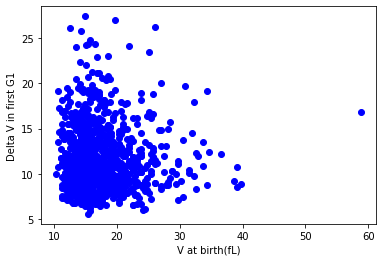

In [100]:
pop_dir = './MM/growth-15/'
plot_deltaVG1_birthsize(pop_dir)

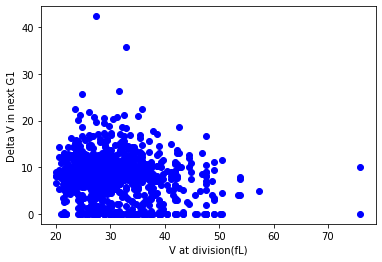

In [104]:
pop_dir = './MM/growth-15/'
plot_Vdiv_VG1(pop_dir)

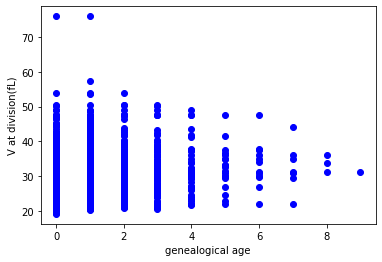

In [103]:
pop_dir = './MM/growth-15/'
plot_Vdiv_gen(pop_dir)

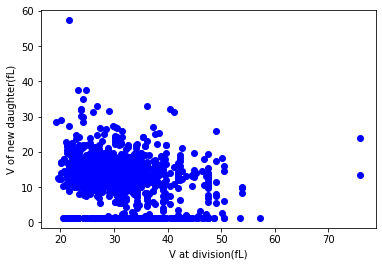

In [102]:
pop_dir = './MM/growth-15/'
plot_Vdiv_Vbirth(pop_dir)

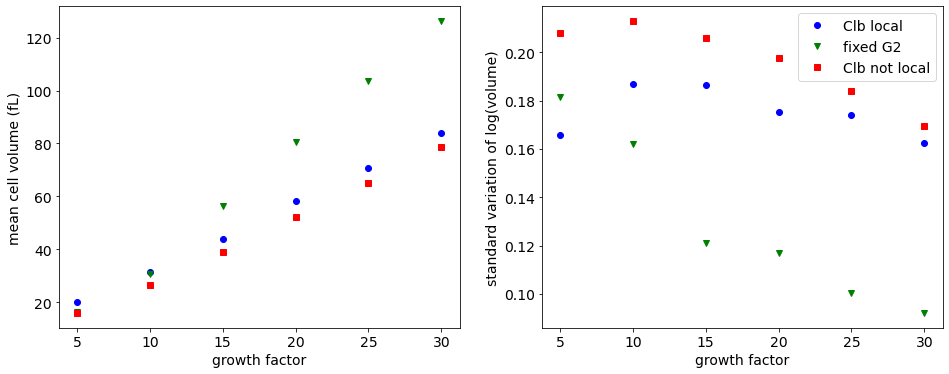

In [11]:
dire = ['./MM/growth-','./MM_noCLB/growth-','./MM_CLBnoLOC/growth-']
growth = [5,10,15,20,25,30]
labels=['Clb local','fixed G2', 'Clb not local']
plot_size_distr(dire,growth,labels)

1200 1200 1200
1200 1200 1200
1200 1200 1200
1200 1200 1200


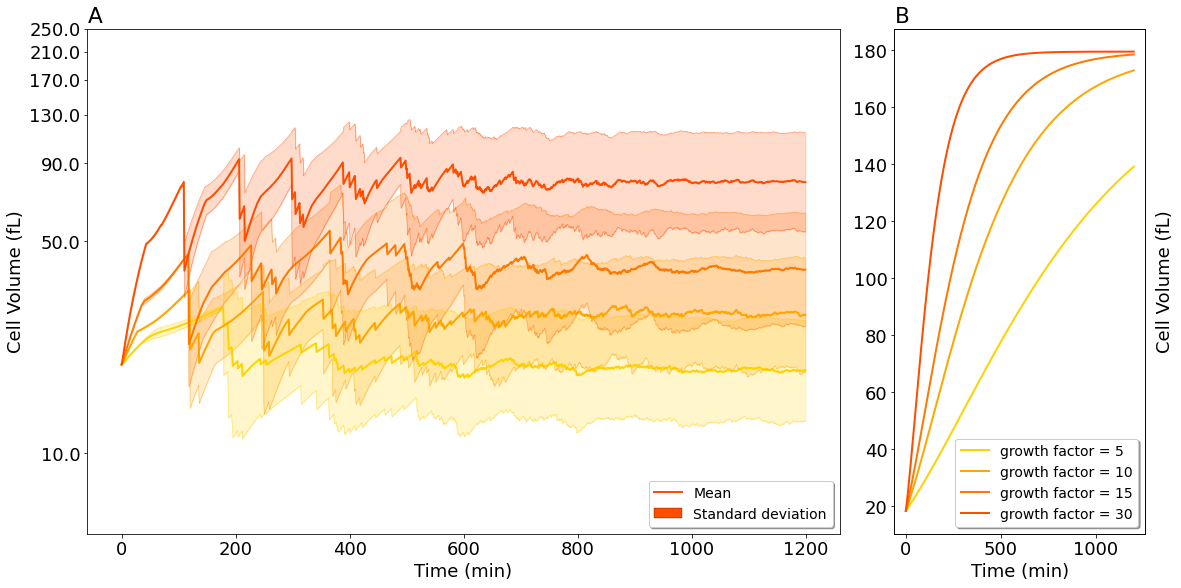

In [9]:
pop_dires = ['./MM/growth-5/','./MM/growth-10/','./MM/growth-15/','./MM/growth-30/']
single_dires = ['./MM/single-growth-5/','./MM/single-growth-10/','./MM/single-growth-15/','./MM/single-growth-30/']
labels=['growth factor = 5','growth factor = 10','growth factor = 15','growth factor = 30']
save_dir='./'
plot_vol_pop_single(pop_dires,single_dires ,labels, 'Volume_growthfactor', save_dir,0,1200)

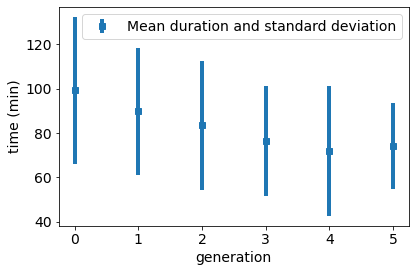

In [23]:
pop_dir = './MM_cB/growth-10/'
save_dir = './'
#plot_G1(pop_dir,save_dir)
plot_G2(pop_dir,save_dir)
#plot_pop_volume_life(pop, 'Time (min)', 'Cell volume (fL)', 'lifecycle_V_'+filename_sim+'.pdf', 1, 10000, save_dir)
#Parallel(n_jobs=-1)(delayed(plot_species)(pop[cell_nr],save_dir,cell_nr) for cell_nr in range(min(len(pop),10)))
    

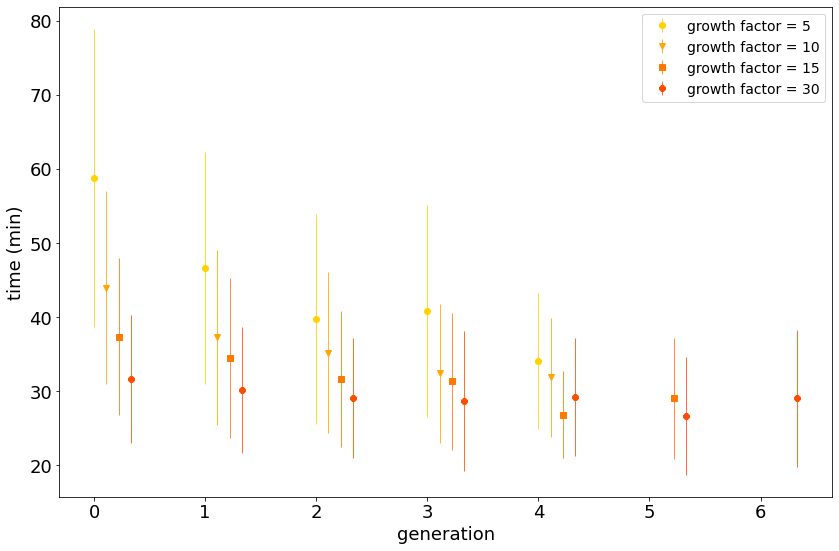

In [10]:
dires = ['./MM/growth-5/','./MM/growth-10/','./MM/growth-15/','./MM/growth-30/']
save_dir = './'
labels=['growth factor = 5','growth factor = 10','growth factor = 15','growth factor = 30']
plot_G1_growth(dires,labels,save_dir)

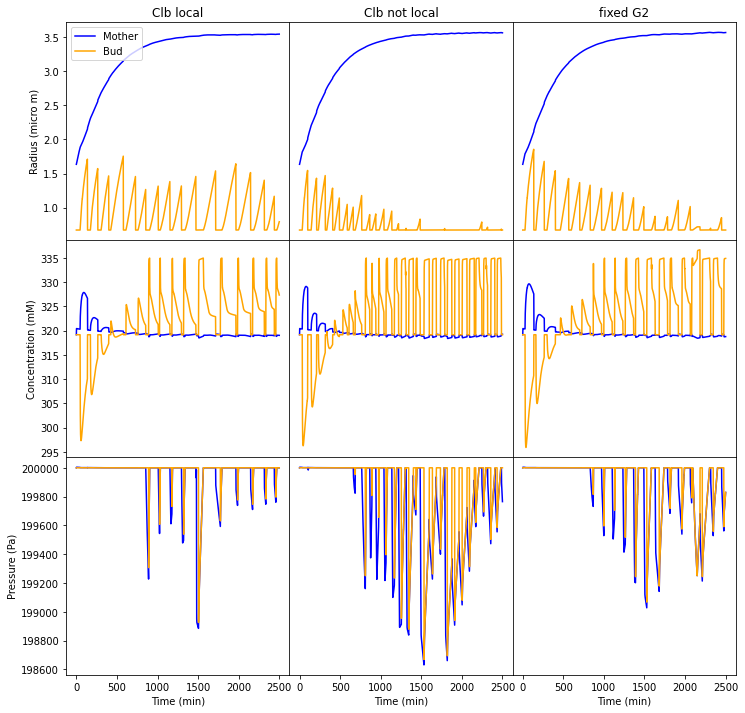

In [323]:
dires = ['./MM/coupled-growth-10-2500/','./MM_CLBnoLOC/coupled-growth-10-2500/','./MM_noCLB/coupled-growth-10-2500/']
save_dir = './'
labels=['Clb local', 'Clb not local','fixed G2']
plot_coupled_sim(dires,labels,save_dir)

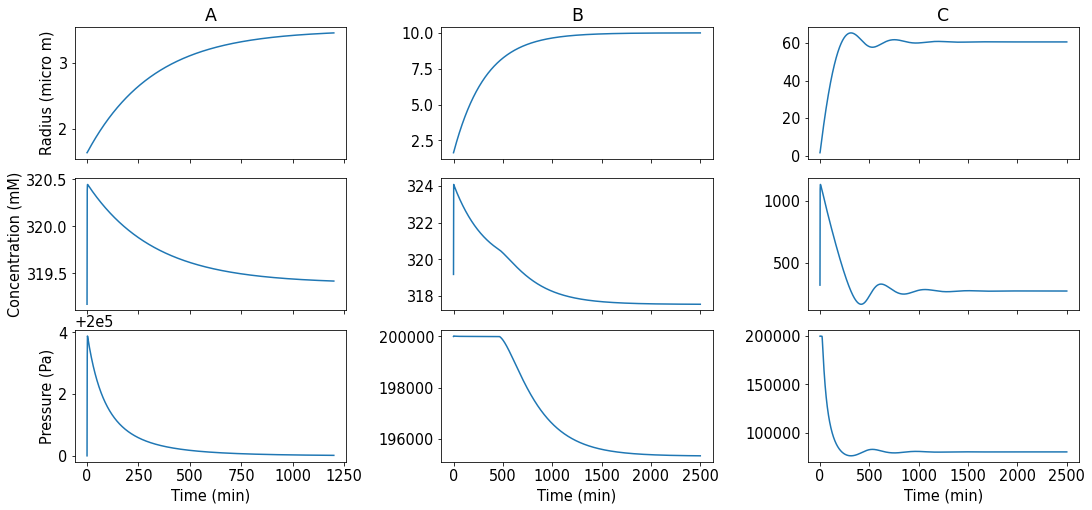

In [51]:
dires=['./MM/single-growth-10/','./MM/critical-size/','./MM/oscillation/']
titles = ['A','B','C']
save_dir = './'
plot_single_r_ci_pi(dires,titles,save_dir)

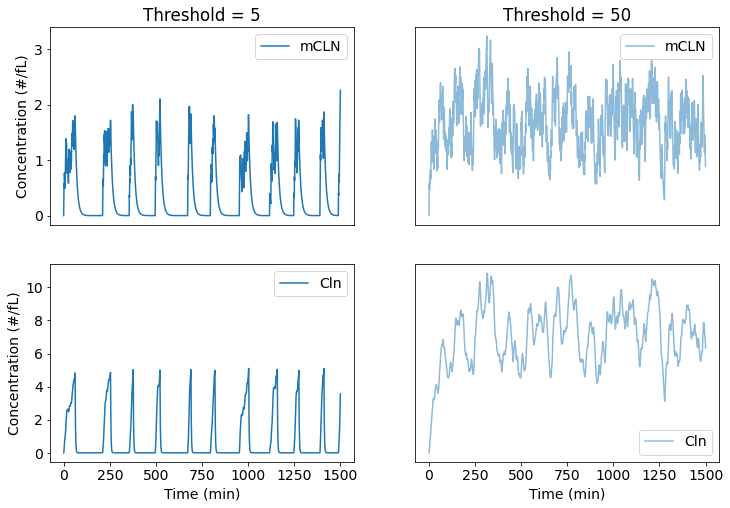

In [21]:
dires=['./MM_cB/growth-10/','./MM_cB/single/']
titles = ['Threshold = 5','Threshold = 50']
save_dir = './'
plot_single_cyclin(dires,titles,save_dir)

1.6033101111344261 0.1886199747190093


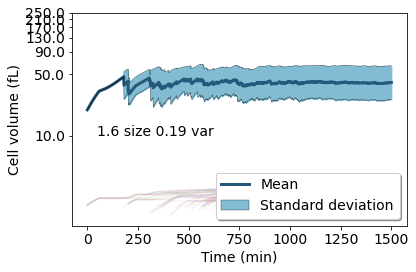

In [18]:
pop_dir = './MM_cB/growth-10/'
save_dir = pop_dir
#pop = pickle.load(open(pop_dir+'pop.p','rb'))
plot_pop_volume_life(pop_dir, 'Time (min)', 'Cell volume (fL)', 'lifecycle_V_test.pdf', 1, 10000, save_dir)